In [1]:
import pandas as pd
import geopandas as gp
import numpy as np 
import os
import fiona
from statistics import mean, median
import string

# VEST OH 2020
---

## VEST Documentation

### Election Results

#### Sources
Election results from the Ohio Secretary of State (https://www.sos.state.oh.us/elections/election-results-and-data/). 

#### Processing Part 1
The following counties include adjustments to account for corporate annexations that are not specified below by precinct: Adams, Athens, Butler, Franklin, Guernsey, Montgomery, Stark, Tuscarawas, Warren, Wayne.

#### Processing Part 2 (unclear whether this is for election results, shapefiles, or both)
The following additional revisions were made to match the 2020 precinct boundaries:

- **Athens:** Adjust Athens 4-4/4-5, Nelsonville 1/2/3/4
- **Brown:** Adjust Perry Twp South/Villages
- **Butler:** Adjust Hamilton 22/24, Oxford 6/11, Trenton 5/7, West Chester 28/39
- **Champaign:** Adjust Union N/S
- **Clark:** Align New Carlisle, Springfield precincts with county maps
- **Crawford:** Move eastern Polk Twp from Galion 1B to western Polk Twp
- **Cuyahoga:** Adjust Olmsted Twp D/F/H
- **Delaware:** Adjust Berlin C/Delaware 3-F
- **Fairfield:** Adjust Greenfield B/Lancaster 2-A, Pickerington F/Violet B/Violet C
- **Greene:** Adjust Bath 277/Fairborn 226/Xenia 351
- **Hamilton:** Adjust Cleves A/Whitewater A, Colerain BB/F
- **Knox:** Adjust Clinton A/Mount Vernon 1-B, Clinton B/Mount Vernon 2-A
- **Lake:** Adjust Painesville A/K
- **Medina:** Adjust Wadsworth City 1-D/Sharon D, Wadsworth City 2-D/Twp C
- **Richland:** Adjust Ontario 3/4
- **Stark:** Adjust Canton 8-C/Plain 6, Canton 6-A/Plain 12
- **Summit:** Adjust Coventry D/G, Hudson 1-B/3-C, Springfield F/J
- **Warren:** Adjust Mason City Z/Union A, South Lebanon A/B


### Shapefiles

#### Sources
Precinct shapefile from the U.S. Census Bureau's 2020 Redistricting Data Program final release. Note that some VTDs were relabeled to match precinct names and/or precinct codes in the November 2020 general election returns.

# Election Result Processing

## Get VEST file and FIPS dictionary ready

### Load in VEST file

In [2]:
vest_oh_20 = gp.read_file("./raw-from-source/VEST/oh_2020/oh_2020.shp")

In [3]:
vest_oh_20.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

<AxesSubplot:>

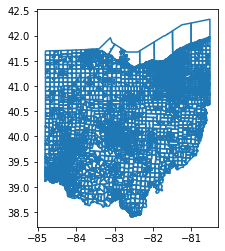

In [4]:
vest_oh_20.boundary.plot()

In [5]:
vest_oh_20.columns

Index(['STATEFP20', 'COUNTYFP20', 'VTDST20', 'PRECINCT20', 'GEOID20', 'NAME20',
       'G20PRERTRU', 'G20PREDBID', 'G20PRELJOR', 'G20PREGHAW', 'geometry'],
      dtype='object')

### Create a FIPs dictionary for OH

In [6]:
#Load in the nationwide FIPS file
fips_file = pd.read_csv("./raw-from-source/FIPS/US_FIPS_Codes.csv")
fips_file = fips_file[fips_file["State"]=="Ohio"]
fips_file["FIPS County"]=fips_file["FIPS County"].astype(str)

#Make the FIPS three digits
fips_file["FIPS County"]=fips_file["FIPS County"].str.zfill(3)

#Create the dictionary
oh_fips_dict = dict(zip(fips_file["County Name"],fips_file["FIPS County"]))

## Load and Clean Election Results

### Load Election Results

Cleaned the `statewideresultsbyprecinct.xlsx` file by hand, and created `statewideresultsbyprecinct_clean.csv`. No modifications were made to the election results. Unnecessary tabs were removed and column names were renamed to match VEST's manually. 

In [7]:
#Load in clean SOS file
elections_2020 = pd.read_csv("./raw-from-source/SOS/statewideresultsbyprecinct_clean.csv")

In [8]:
elections_2020.shape

(8933, 9)

In [9]:
elections_2020.head()

,County Name,Precinct Name,Precinct Code,Registered Voters,Ballots Counted,G20PREDBID,G20PREGHAW,G20PRELJOR,G20PRERTRU
0,Adams,BRATTON TOWNSHIP,AAA,957,738,118,2,6,605
1,Adams,BRUSH CREEK TOWNSHIP,AAB,773,547,90,4,4,442
2,Adams,LOCUST GROVE,AAD,719,550,80,1,3,460
3,Adams,GREEN TOWNSHIP,AAE,401,289,54,0,2,230
4,Adams,JEFFERSON TOWNSHIP,AAG,498,329,60,0,1,266


In [10]:
#Map to the correct FIP
elections_2020["county"]=elections_2020["County Name"].map(oh_fips_dict).fillna(elections_2020["County Name"])

#Print out the FIPS to make sure they all are in the correct format
elections_2020["county"].unique()

array(['001', '003', '005', '007', '009', '011', '013', '015', '017',
       '019', '021', '023', '025', '027', '029', '031', '033', '035',
       '037', '039', '041', '043', '045', '047', '049', '051', '053',
       '055', '057', '059', '061', '063', '065', '067', '069', '071',
       '073', '075', '077', '079', '081', '083', '085', '087', '089',
       '091', '093', '095', '097', '099', '101', '103', '105', '107',
       '109', '111', '113', '115', '117', '119', '121', '123', '125',
       '127', '129', '131', '133', '135', '137', '139', '141', '143',
       '145', '147', '149', '151', '153', '155', '157', '159', '161',
       '163', '165', '167', '169', '171', '173', '175'], dtype=object)

## Compare Election Results Totals

### Compare Total Votes

In [11]:
races = [x for x in vest_oh_20.columns if 'G20' in x]
races

['G20PRERTRU', 'G20PREDBID', 'G20PRELJOR', 'G20PREGHAW']

In [12]:
sum_var_1 = 0
sum_var_2 = 0
for i in races:
    sum_var_1 += np.sum(vest_oh_20[i])
    sum_var_2 += np.sum(elections_2020[i])
print(sum_var_1)
print(sum_var_2)

5920380
5920380


### Compare Race Totals

In [13]:
def statewide_totals_check(partner_df,source_df,column_list):
    print("***Statewide Totals Check***")
    for race in column_list:
        if (sum(partner_df[race])- source_df[race].sum() != 0):
            print(race+" has a difference of "+str(sum(partner_df[race])-source_df[race].sum())+" votes")
            print("\tVEST: "+str(sum(partner_df[race]))+" votes")
            print("\tSOURCES: "+str(source_df[race].sum())+" votes")
        else:
            print(race + " is equal", "\tVEST / RDH: " + str(sum(partner_df[race])))

In [14]:
statewide_totals_check(vest_oh_20,elections_2020,races)

***Statewide Totals Check***
G20PRERTRU is equal 	VEST / RDH: 3154834
G20PREDBID is equal 	VEST / RDH: 2679165
G20PRELJOR is equal 	VEST / RDH: 67569
G20PREGHAW is equal 	VEST / RDH: 18812


### Compare County Totals

In [15]:
#Have a matching county column
elections_2020["COUNTYFP20"] = elections_2020["county"]

In [16]:
def county_totals_check(partner_df,source_df,column_list,county_col,full_print=False):
    print("***Countywide Totals Check***")
    print("")
    diff_counties=[]
    for race in column_list:
        diff = partner_df.groupby([county_col]).sum()[race]-source_df.groupby([county_col]).sum()[race]
        for val in diff[diff != 0].index.values.tolist():
            if val not in diff_counties:
                diff_counties.append(val)
        if len(diff[diff != 0]!=0):   
            print(race + " contains differences in these counties:")
            for val in diff[diff != 0].index.values.tolist():
                county_differences = diff[diff != 0]
                print("\t"+val+" has a difference of "+str(county_differences[val])+" votes")
                print("\t\tVEST: "+str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")
                print("\t\tSOURCES: "+str(source_df.groupby([county_col]).sum().loc[val,race])+" votes")
            if (full_print):
                for val in diff[diff == 0].index.values.tolist():
                    county_similarities = diff[diff == 0]
                    print("\t"+val + ": "+ str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")
        else:
            print(race + " is equal across all counties")
            if (full_print):
                for val in diff[diff == 0].index.values.tolist():
                    county_similarities = diff[diff == 0]
                    print("\t"+val + ": "+ str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")

In [17]:
#elections_2020.groupby(["COUNTYFP20"]).sum().to_csv("./county_totals.csv")

In [18]:
county_totals_check(vest_oh_20,elections_2020,races,"COUNTYFP20",full_print=False)

***Countywide Totals Check***

G20PRERTRU is equal across all counties
G20PREDBID is equal across all counties
G20PRELJOR is equal across all counties
G20PREGHAW is equal across all counties


### Compare Precinct Totals

In [19]:
elections_2020["unique_ID"] = elections_2020["county"]+"-"+elections_2020["Precinct Code"]
vest_oh_20["unique_ID"] = vest_oh_20["COUNTYFP20"]+"-"+vest_oh_20["PRECINCT20"]

In [20]:
#Confirm unique IDs are unique
print(elections_2020["unique_ID"].value_counts(dropna=False))
print(vest_oh_20["unique_ID"].value_counts(dropna=False))

095-AHR    1
035-CRE    1
021-AAH    1
035-CBA    1
057-ACD    1
          ..
035-AUZ    1
087-ABX    1
057-AFA    1
137-ABK    1
101-ACJ    1
Name: unique_ID, Length: 8933, dtype: int64
025-AHJ    1
061-BLW    1
033-ABK    1
049-AFA    1
049-AWO    1
          ..
085-AGS    1
035-AUZ    1
087-ABX    1
147-AAS    1
101-ACJ    1
Name: unique_ID, Length: 8941, dtype: int64


In [21]:
attempt_one = pd.merge(elections_2020,vest_oh_20,how="outer",on="unique_ID",indicator=True)
print(attempt_one["_merge"].value_counts())

elections_only = attempt_one[attempt_one["_merge"]=="left_only"]
vest_only = attempt_one[attempt_one["_merge"]=="right_only"]

attempt_one[attempt_one["_merge"]=="left_only"].to_csv("./source.csv")
attempt_one[attempt_one["_merge"]=="right_only"].to_csv("./vest.csv")

both          8933
right_only       8
left_only        0
Name: _merge, dtype: int64


In [22]:
#Confirm these are all zero-vote races
races_x =["unique_ID"]
races_y =["unique_ID"]

for val in races:
    races_x.append(val+"_x")
    races_y.append(val+"_y")

print((vest_only[races_y]))
display(list(vest_only[races_y]["unique_ID"]))

     unique_ID  G20PRERTRU_y  G20PREDBID_y  G20PRELJOR_y  G20PREGHAW_y
8933   093-ZZZ             0             0             0             0
8934   123-ZZZ             0             0             0             0
8935   095-ZZZ             0             0             0             0
8936   043-ZZZ             0             0             0             0
8937   085-ZZZ             0             0             0             0
8938   035-ZZZ             0             0             0             0
8939   133-ZZZ             0             0             0             0
8940   007-ZZZ             0             0             0             0


['093-ZZZ',
 '123-ZZZ',
 '095-ZZZ',
 '043-ZZZ',
 '085-ZZZ',
 '035-ZZZ',
 '133-ZZZ',
 '007-ZZZ']

In [23]:
def precinct_votes_check(merged_df,column_list,vest_on_left,name_col,print_level=0):
    merged_df = merged_df.sort_values(by=[name_col],inplace=False)
    matching_rows = 0
    different_rows = 0
    diff_list=[]
    diff_values = []
    max_diff = 0
    for index,row in merged_df.iterrows():
        same = True
        for i in column_list:
            left_data = i + "_x"
            right_data = i + "_y"
            if ((row[left_data] is None) or (row[right_data] is None) or (np.isnan(row[right_data])or(np.isnan(row[left_data])))):
                print("FIX NaN value at: ", row[name_col])
                return;
            diff = abs(row[left_data]-row[right_data])
            if (diff>0):
                same = False
                diff_values.append(abs(diff))
                if (diff>max_diff):
                    max_diff = diff
            if(diff>print_level):
                if (vest_on_left):
                    print(i, "{:.>72}".format(row[name_col]), "(V)","{:.>5}".format(int(row[left_data]))," (S){:.>5}".format(int(row[right_data])),"(D):{:>5}".format(int(row[left_data]-row[right_data])))                           
                else:
                    print(i, "{:.>72}".format(row[name_col]), "(S)","{:.>5}".format(int(row[left_data]))," (V){:.>5}".format(int(row[right_data])),"(D):{:>5}".format(int(row[left_data]-row[right_data])))
        if(same != True):
            different_rows +=1
            diff_list.append(row[name_col])
        else:
            matching_rows +=1
    print("")
    print("There are ", len(merged_df.index)," total rows")
    print(different_rows," of these rows have election result differences")
    print(matching_rows," of these rows are the same")
    print("")
    print("The max difference between any one shared column in a row is: ", max_diff)
    if(len(diff_values)!=0):
        print("The average difference is: ", str(sum(diff_values)/len(diff_values)))
    count_big_diff = len([i for i in diff_values if i > 10])
    print("There are ", str(count_big_diff), "precinct results with a difference greater than 10")
    print("")
    print("All precincts containing differences:")
    diff_list.sort()
    print(diff_list)

In [24]:
precinct_votes_check(attempt_one[attempt_one["_merge"]=="both"],races,False,"unique_ID",print_level=0)


There are  8933  total rows
0  of these rows have election result differences
8933  of these rows are the same

The max difference between any one shared column in a row is:  0
There are  0 precinct results with a difference greater than 10

All precincts containing differences:
[]


# Precinct Shapefile

## Load in the shapefiles

### 2020 TIGER/Line

> Precinct shapefiles primarily from the U.S. Census Bureau's 2020 Redistricting Data Program final release

Link to the 2020 TIGER/Line files for Ohio, where we can download the VTD file: 
https://www2.census.gov/geo/tiger/TIGER2020PL/STATE/39_OHIO/39/

In [25]:
tiger_vtd = gp.read_file('./raw-from-source/Census/tl_2020_39_vtd20/tl_2020_39_vtd20.shp')

<AxesSubplot:>

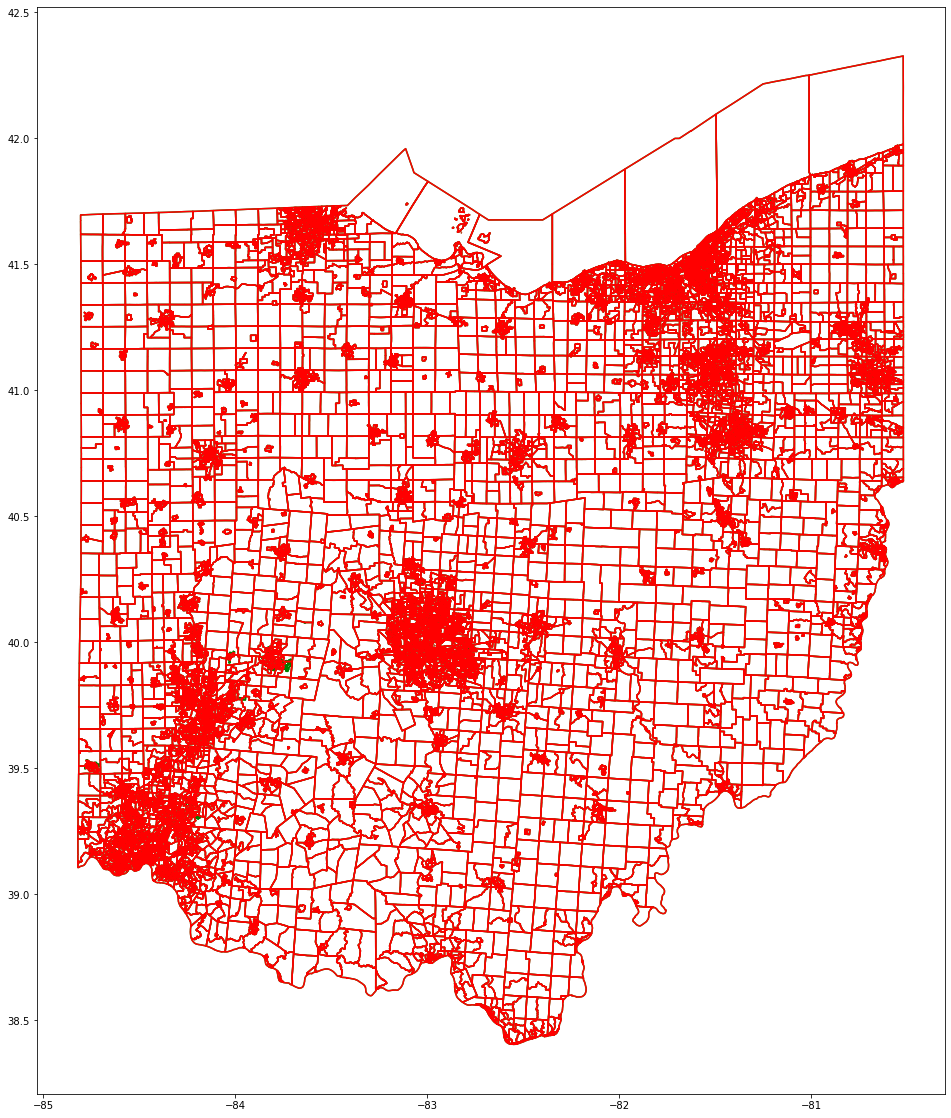

In [26]:
#Plot what they look like on top of one another, looks similar to what VEST has
ax = tiger_vtd.boundary.plot(figsize=(20,20),color="green")
vest_oh_20.boundary.plot(figsize=(20,20),ax=ax,color="red")

With a cursory look, this looks correct. 

In [27]:
tiger_vtd["unique_ID"] = tiger_vtd["COUNTYFP20"]+"-"+tiger_vtd["VTDST20"].str[3:6]
final_source = pd.merge(elections_2020,tiger_vtd,how="outer",on="unique_ID",indicator=True)
final_source["_merge"].value_counts()

both          8933
right_only       8
left_only        0
Name: _merge, dtype: int64

In [28]:
final_source[final_source["_merge"]=="right_only"]

,County Name,Precinct Name,Precinct Code,Registered Voters,Ballots Counted,G20PREDBID,G20PREGHAW,G20PRELJOR,G20PRERTRU,county,...,NAMELSAD20,LSAD20,MTFCC20,FUNCSTAT20,ALAND20,AWATER20,INTPTLAT20,INTPTLON20,geometry,_merge
8933,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Voting Districts Not Defined,00,G5240,S,0,1109628722,+41.6327688,-082.1519465,"POLYGON ((-82.34818 41.43194, -82.34816 41.441...",right_only
8934,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Voting Districts Not Defined,00,G5240,S,36444,814010222,+41.5912825,-082.8326324,"MULTIPOLYGON (((-82.97457 41.46828, -82.97418 ...",right_only
8935,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Voting Districts Not Defined,00,G5240,S,24193,640025374,+41.6410366,-083.2204757,"POLYGON ((-83.47858 41.70229, -83.47857 41.702...",right_only
8936,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Voting Districts Not Defined,00,G5240,S,0,950349402,+41.5450831,-082.5456584,"MULTIPOLYGON (((-82.70569 41.61082, -82.70561 ...",right_only
8937,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Voting Districts Not Defined,00,G5240,S,0,1937202372,+41.9759747,-081.2553317,"POLYGON ((-81.49518 42.09640, -81.45429 42.116...",right_only
8938,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Voting Districts Not Defined,00,G5240,S,0,2010659884,+41.7602901,-081.7241578,"POLYGON ((-81.97058 41.87785, -81.87486 41.922...",right_only
8939,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Voting Districts Not Defined,00,G5240,S,81725355,0,+41.1960556,-081.0913779,"POLYGON ((-81.19275 41.19287, -81.19252 41.192...",right_only
8940,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Voting Districts Not Defined,00,G5240,S,0,1705206498,+42.0985964,-080.7705575,"POLYGON ((-81.00983 42.25160, -81.00557 42.252...",right_only


### Add in these zero-vote precincts to the election results

In [29]:
zero_votes= pd.DataFrame(columns=elections_2020.columns)
zero_votes["County Name"]=['Lorain','Ottawa','Lucas','Erie','Lake','Cuyahoga','Portage','Ashtabula']
zero_votes["Precinct Name"] = ["Voting District Not Defined"] * 8
zero_votes["Precinct Code"] = ["ZZZ"] * 8
zero_votes["G20PREDBID"] = [0] * 8
zero_votes["G20PREGHAW"] = [0] * 8
zero_votes["G20PRELJOR"] = [0] * 8
zero_votes["G20PRERTRU"] = [0] * 8
zero_votes["county"] = ["093","123","095","043","085","035","133","007"]
zero_votes["unique_ID"] = list(final_source[final_source["_merge"]=="right_only"]["unique_ID"])

In [30]:
elections_final = pd.concat([elections_2020,zero_votes])
elections_final.reset_index(inplace=True,drop=True)

### Join source files again

In [31]:
tiger_vtd["unique_ID"] = tiger_vtd["COUNTYFP20"]+"-"+tiger_vtd["VTDST20"].str[3:6]
final_source = pd.merge(elections_final,tiger_vtd,how="outer",on="unique_ID",indicator=True)
final_source["_merge"].value_counts()

both          8941
left_only        0
right_only       0
Name: _merge, dtype: int64

### Join to VEST

In [32]:
final_merge = pd.merge(vest_oh_20,final_source,indicator="final_merge",how="outer",on="unique_ID")
final_merge["final_merge"].value_counts()

both          8941
left_only        0
right_only       0
Name: final_merge, dtype: int64

In [33]:
#Create a column for printing in the below code
final_merge["shape_print"]=final_merge["County Name"]+"-"+final_merge["Precinct Name"]

In [34]:
both = final_merge[final_merge["final_merge"]=="both"]
vest_geoms = gp.GeoDataFrame(both,geometry="geometry_x",crs=vest_oh_20.crs)
source_geoms = gp.GeoDataFrame(both,geometry="geometry_y",crs=vest_oh_20.crs)
source_geoms = source_geoms.to_crs(3857)
vest_geoms = vest_geoms.to_crs(3857)
source_geoms["geometry_x"]=source_geoms.buffer(0)
vest_geoms["geometry_y"]=vest_geoms.buffer(0)
vals = source_geoms.geom_almost_equals(vest_geoms,decimal=0)
print(vals.value_counts())

True     8657
False     284
dtype: int64


In [35]:
source_geoms

,STATEFP20_x,COUNTYFP20,VTDST20_x,PRECINCT20,GEOID20_x,NAME20_x,G20PRERTRU_x,G20PREDBID_x,G20PRELJOR_x,G20PREGHAW_x,...,MTFCC20,FUNCSTAT20,ALAND20,AWATER20,INTPTLAT20,INTPTLON20,geometry_y,_merge,final_merge,shape_print
0,39,009,005ACR,ACR,39009005ACR,ATHENS 2-5,6,7,0,0,...,G5240,N,128384,1292,+39.3235059,-082.0932670,"POLYGON ((-9138920.133 4767916.196, -9138915.0...",both,both,Athens-ATHENS 2-5
1,39,159,080ABZ,ABZ,39159080ABZ,MARYSVILLE 2,356,204,14,0,...,G5240,N,1763457,87555,+40.2586593,-083.3584949,"POLYGON ((-9280396.439 4903002.130, -9280390.9...",both,both,Union-MARYSVILLE 2
2,39,159,080ACC,ACC,39159080ACC,JEROME 6,414,341,6,1,...,G5240,N,12250865,132509,+40.1866056,-083.1911984,"POLYGON ((-9265303.122 4889379.414, -9265292.1...",both,both,Union-JEROME 6
3,39,159,080ACA,ACA,39159080ACA,MARYSVILLE 4,395,231,4,3,...,G5240,N,911476,11038,+40.2266082,-083.3715786,"POLYGON ((-9282330.287 4897955.707, -9282252.9...",both,both,Union-MARYSVILLE 4
4,39,159,080ACB,ACB,39159080ACB,MARYSVILLE 15,444,283,10,1,...,G5240,N,1019222,18392,+40.2705858,-083.3795550,"POLYGON ((-9283654.199 4904119.936, -9283642.1...",both,both,Union-MARYSVILLE 15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8936,39,049,025AZR,AZR,39049025AZR,JEFFERSON-A,500,469,13,1,...,G5240,N,4886693,59214,+40.0397103,-082.8325518,"MULTIPOLYGON (((-9220276.698 4873299.969, -922...",both,both,Franklin-JEFFERSON-A
8937,39,165,083AGD,AGD,39165083AGD,DEERFIELD TWP D,358,391,4,3,...,G5240,N,1480877,0,+39.3618808,-084.3423088,"MULTIPOLYGON (((-9387391.710 4774366.061, -938...",both,both,Warren-DEERFIELD TWP D
8938,39,153,077AEL,AEL,39153077AEL,AKRON 6-E,348,296,4,2,...,G5240,N,903461,0,+41.0447408,-081.4363073,"POLYGON ((-9066409.698 5018551.152, -9066410.1...",both,both,Summit-AKRON 6-E
8939,39,153,077AVS,AVS,39153077AVS,SPRINGFIELD TWP F,411,201,7,2,...,G5240,N,2507489,673625,+41.0344399,-081.4408419,"POLYGON ((-9067365.926 5016244.383, -9067366.9...",both,both,Summit-SPRINGFIELD TWP F


1) For both difference in area is 2.4621248774367808
2) For both difference in area is 2.4621248774367803
3) For both difference in area is 0.33135489784848227
4) For both difference in area is 0.5340140757496866
5) For both difference in area is 0.2026591779012044
6) For both difference in area is 0.30408248785128067
7) For both difference in area is 0.2927626927155917
8) For both difference in area is 0.1742661864517079
9) For both difference in area is 0.17555131271224073
10) For both difference in area is 0.116830202643772
11) For both difference in area is 0.1555430334656136
12) For both difference in area is 0.9479387895957018
13) For both difference in area is 0.2987446878782231
14) For both difference in area is 0.22186179752519714
15) For both difference in area is 0.22186179752519722
16) For both difference in area is 0.977730060127433
17) For both difference in area is 0.15351384429055295
18) For both difference in area is 0.13996560599897134
19) For both difference in area 

/Users/peterhorton/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/geopandas/plotting.py:384: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=figsize)


23) For both difference in area is 0.10061173866921654
24) For both difference in area is 0.2128194192925163
25) For both difference in area is 0.3305200600365048
26) For both difference in area is 0.10061173866921656
27) For both difference in area is 0.2564595372704101
28) For both difference in area is 0.27201017527635


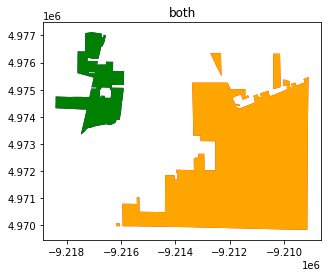

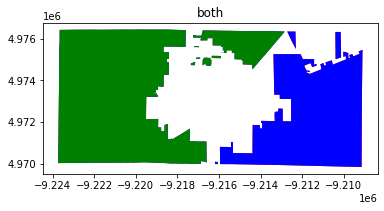

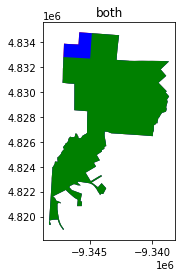

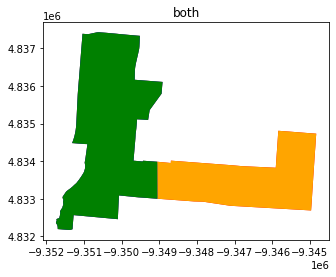

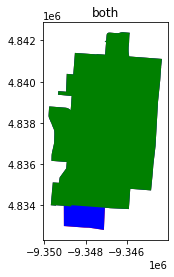

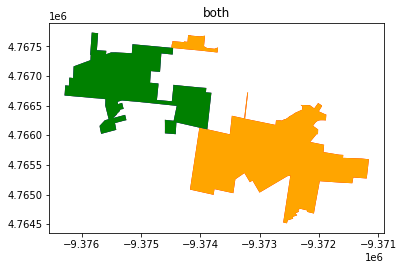

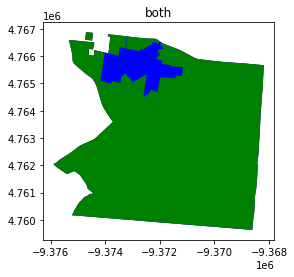

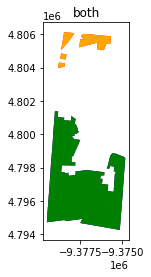

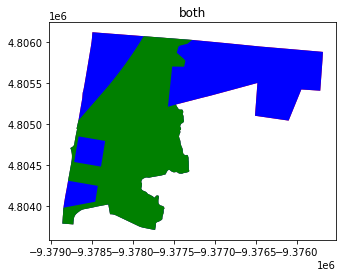

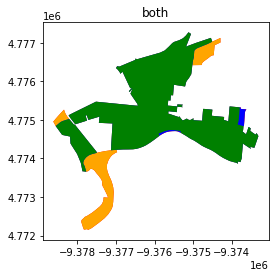

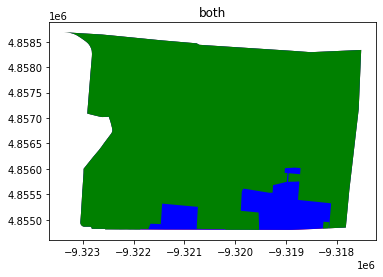

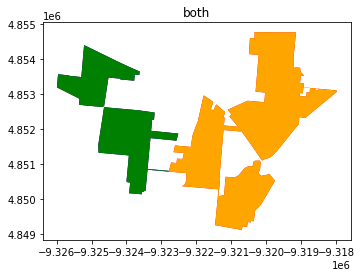

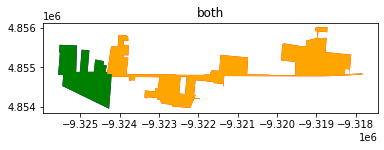

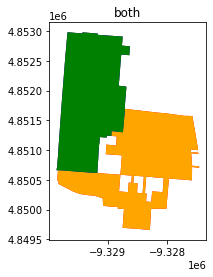

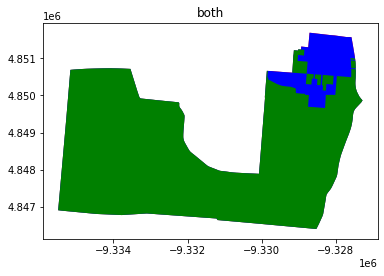

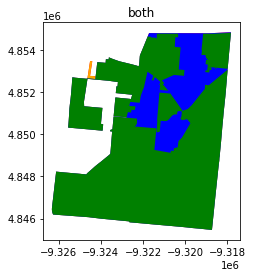

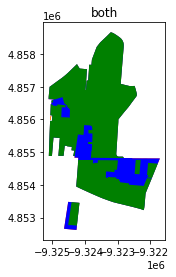

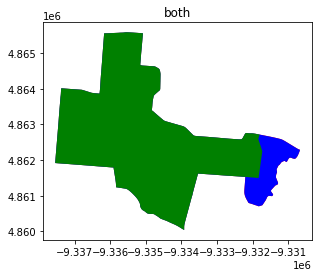

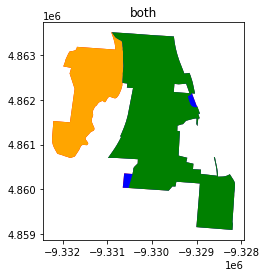

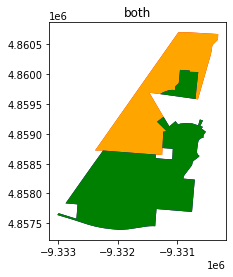

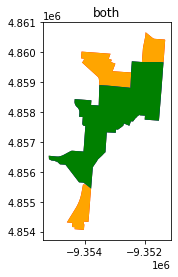

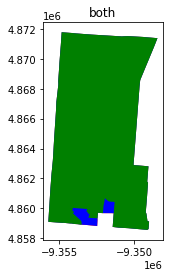

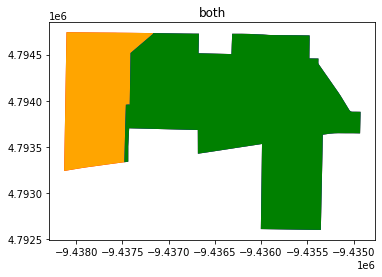

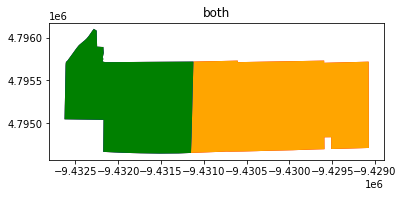

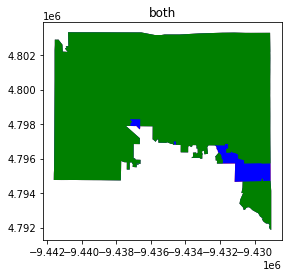

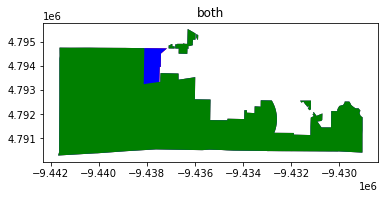

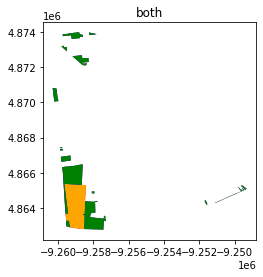

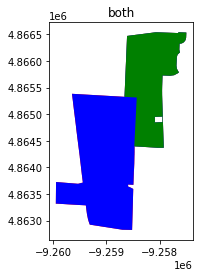

In [36]:
count = 0
area_list = []
for i in range(0,len(source_geoms)):
    diff = source_geoms.iloc[[i]].symmetric_difference(vest_geoms.iloc[[i]])
    intersection = source_geoms.iloc[[i]].intersection(vest_geoms.iloc[[i]])
    area = float(diff.area/10e6)
    area_list.append(area)
    #print("Area is " + str(area))

    if (area > .1):
        count += 1
        name = source_geoms.iat[i,39]
        
        print(str(count)+") For " + name + " difference in area is " + str(area))
        if (intersection.iloc[0].is_empty):
            base = diff.plot(color="red")
            source_geoms.iloc[[i]].plot(color="orange",ax=base)
            vest_geoms.iloc[[i]].plot(color="blue",ax=base)
            base.set_title(name)
        else:
            base = diff.plot(color="red")
            source_geoms.iloc[[i]].plot(color="orange",ax=base)
            vest_geoms.iloc[[i]].plot(color="blue",ax=base)
            intersection.plot(color="green",ax=base)
            base.set_title(name)

In [37]:
df = pd.DataFrame(area_list)
print(df.shape)

print(str(len(df[df[0]==0]))+" precincts w/ a difference of 0 km^2")
print(str(len(df[(df[0]<.1) & (df[0]>0)]))+ " precincts w/ a difference between 0 and .1 km^2")
print(str(len(df[(df[0]<.5) & (df[0]>=.1)]))+ " precincts w/ a difference between .1 and .5 km^2")
print(str(len(df[(df[0]<1) & (df[0]>=.5)]))+ " precincts w/ a difference between .5 and 1 km^2")
print(str(len(df[(df[0]<2) & (df[0]>=1)]))+ " precincts w/ a difference between 1 and 2 km^2")
print(str(len(df[(df[0]<5) & (df[0]>=2)]))+ " precincts w/ a difference between 2 and 5 km^2")
print(str(len(df[(df[0]>=5)]))+ " precincts w/ a difference greater than 5 km^2")

(8941, 1)
8659 precincts w/ a difference of 0 km^2
254 precincts w/ a difference between 0 and .1 km^2
23 precincts w/ a difference between .1 and .5 km^2
3 precincts w/ a difference between .5 and 1 km^2
0 precincts w/ a difference between 1 and 2 km^2
2 precincts w/ a difference between 2 and 5 km^2
0 precincts w/ a difference greater than 5 km^2
